# ARIMA model 

**OBJECTIFS:**

1. Charger et visualiser les donn√©es.
2. Entra√Æner nos mod√®les et faire des pr√©dictions.

**PREAMBULE:**

1. TERMINOLOGIE:
                         
* **AR : < Auto Regressive >** signifie que le mod√®le utilise la relation d√©pendante entre une observation et un certain nombre pr√©d√©fini d'observations d√©cal√©es (√©galement appel√© "d√©calage temporel" ou "lag").

* **I:< Integrated >** signifie que le mod√®le utilise la diff√©renciation des observations brutes (par exemple, il soustrait une observation d'une observation au pas de temps pr√©c√©dent) afin de rendre la s√©rie temporelle stationnaire.MA :

* **MA : < Moving Average >** signifie que le mod√®le exploite la relation entre l'erreur r√©siduelle et les observations.

2. PARAMETRES DU MODELE :

* **p** est le nombre d'observations du d√©calage.

* **d** est le degr√© de diff√©rentiation.

* **q** est la taille/largeur de la fen√™tre de la moyenne mobile.






## Etape 1: Charger et inspecter les donn√©es

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Chargeons maintenant les donn√©es de l'action Apple.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Google_Colab_stock_prediction/raw_data/AAPL_5.csv"
df= pd.read_csv(path)

In [ ]:
df.head()

Date       Open       High        Low      Close  Adj Close     Volume
0  2016-06-07  24.812500  24.967501  24.740000  24.757500  23.128084   89638000
1  2016-06-08  24.754999  24.889999  24.670000  24.735001  23.107069   83392400
2  2016-06-09  24.625000  24.997499  24.615000  24.912500  23.272882  106405600
3  2016-06-10  24.632500  24.837500  24.620001  24.707500  23.081377  126851600
4  2016-06-13  24.672501  24.780001  24.275000  24.334999  22.733387  152082000

In [ ]:
df.shape

(1258, 7)

In [ ]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

* **Remarque:** Notre target sera la valeur Close.

In [ ]:
y = df.Close

Avant de construire le mod√®le ARIMA, voyons s'il existe une corr√©lation crois√©e dans nos donn√©es

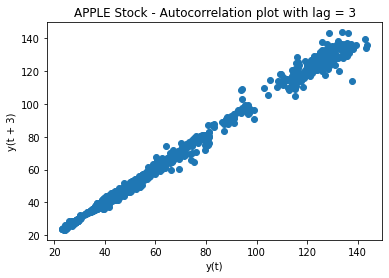

In [ ]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('APPLE Stock - Autocorrelation plot with lag = 3')
plt.show()

Nous pouvons maintenant confirmer que le mod√®le ARIMA sera un bon mod√®le √† appliquer √† ce type de donn√©es (il y a une auto-corr√©lation dans les donn√©es).

## Etape 2: Etude de la stationnarit√©

* **CONTEXTE:** 

Comme nous le voyons dans les param√®tres requis par le mod√®le(cf pr√©ambule 2.), l'utilisation des mod√®les ARIMA requiert que **les s√©ries temporelles soit stationnaire**.
D'o√π la n√©cessit√© de r√©aliser une √©tude de stationnarit√©.

* **TEST DE STATIONNARITE: Augumented Dickey Fuller (ADF) :**

Il s'agit d'un test d‚Äôhypoth√®se permettant de verifier la stationnarit√© de notre time series:

**H0:** la s√©rie temporelle est non stationnaire.

**H1:** la s√©rie temporelle est stationnaire.

**R√©gle de d√©cision:** Ainsi, si la p-value du test est inf√©rieure au seuil de signification (0,05), nous pouvons rejeter l'hypoth√®se nulle et en d√©duire que la s√©rie chronologique est effectivement stationnaire.
Donc, dans notre cas, si la valeur p-value > 0,05, nous devrons trouver l'ordre de diff√©renciation.

In [ ]:
# ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(y.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.013002128813902185
p-value: 0.9595942352120581


Ainsi, notre serie temporelle est non stationnaire.
Pour la rendre stationnaire nous allons utiliser **la differencing Method**:
* Cela signifie que nous prenons la diff√©rence entre chaque valeur et la pr√©c√©dente (premi√®re diff√©rence).
* L'objectif est de repeter ce processus jusqu'√† obtenir l'orde minimum de diff√©rentiation dont nous avons besoin pour rendre notre serie temporelle stationnaire 

Nous allons tracer les courbes d'ACF les visualiser, et imprimez leur p-value adfuller pour √™tre s√ªr

ADF Statistic: 0.013002128813902185
p-value: 0.9595942352120581


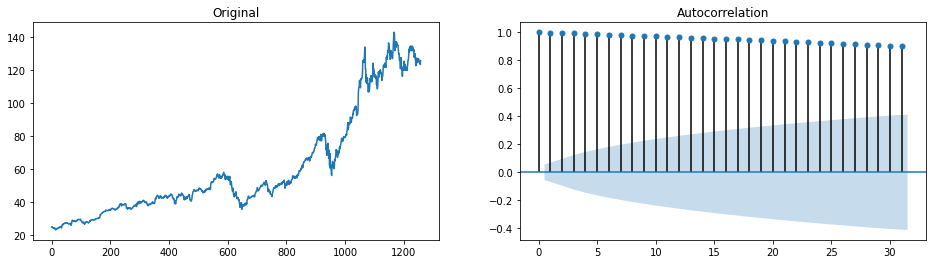

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# ADF Test Original
result = adfuller(y.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(y)
ax1.set_title("Original")
plot_acf(y, ax=ax2);



* **Premi√®re Diff√©rence**

ADF Statistic: -7.405002341662106
p-value: 7.384394662155277e-11


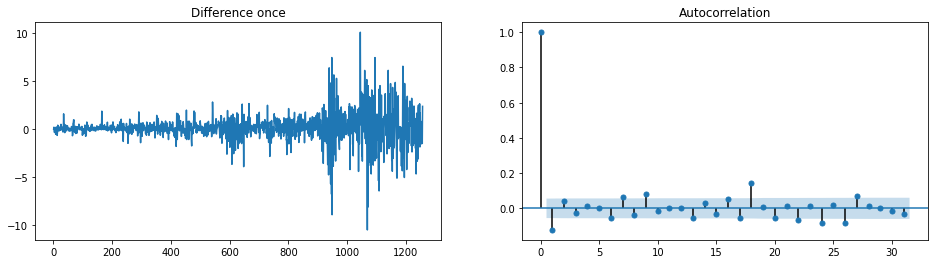

In [ ]:
# ADF Test Premi√®re Diff√©rence
result = adfuller(y.diff(1).dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Premi√®re Diff√©rence
diff = y.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

* **Deuxi√®me Diff√©rence**

ADF Statistic: -16.011386343970926
p-value: 6.350059758222723e-29


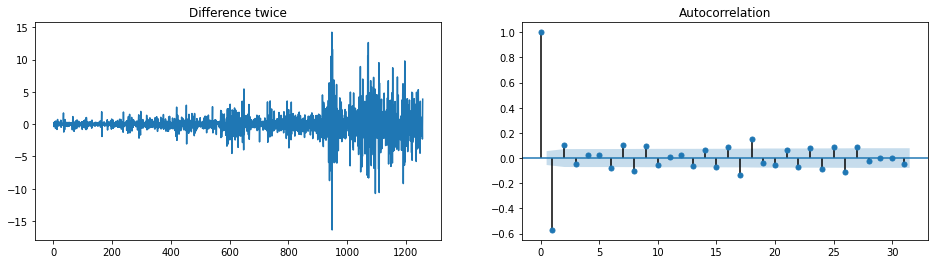

In [ ]:
# ADF Test Deuxi√®me Diff√©rence
result = adfuller(y.diff(1).diff(1).dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Deuxi√®me Diff√©rence
diff = y.diff(1).diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);


* **Notre Choix:** 

Ne gardons qu'un seul ordre de diff et nommons cette s√©rie y_diff (nous pourrons toujours essayer d'autres diff plus tard).

In [ ]:
y_diff = y.diff().dropna()

## Etape 3: Choix du param√®tres ARIMA(p, d, q):

* **Le choix du d :**

Effectuez un test de stationnarit√© pour diff√©rents niveaux de **d** pour estimer le nombre de diff√©rences n√©cessaires pour rendre une s√©rie chronologique donn√©e stationnaire. S√©lectionne la valeur maximale **d** pour laquelle la s√©rie temporelle est jug√©e stationnaire par le test statistique.



In [ ]:
!pip install statsmodels

In [ ]:
!pip install pmdarima

In [ ]:
!pip list 

In [ ]:
from pmdarima.arima import auto_arima

ImportError: ignored

* **Le choix du p :**

**p** est l'ordre du terme autor√©gressif (AR). Il fait r√©f√©rence au nombre de retards √† utiliser comme pr√©dicteurs.

Nous pouvons d√©terminer le nombre requis de termes AR en inspectant le graphique d'autocorr√©lation partielle (PACF).

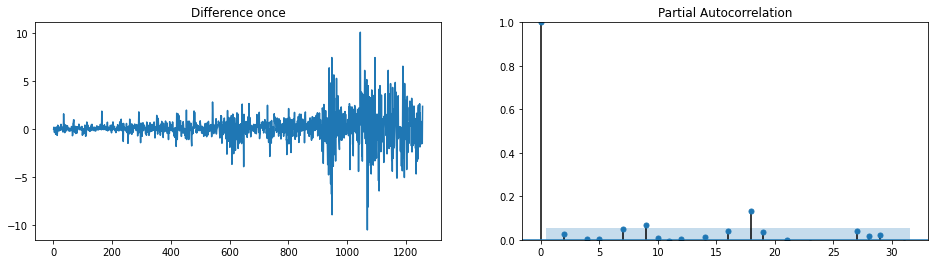

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = y.diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

* **Le choix du q :**

**q** est l'ordre du terme Moving Average (MA). Il s'agit du nombre d'erreurs de pr√©vision d√©cal√©es qui doivent √™tre int√©gr√©es dans le mod√®le ARIMA.

Nous pouvons d√©terminer le nombre requis de termes MA en inspectant le graphique d'autocorr√©lation (ACF).

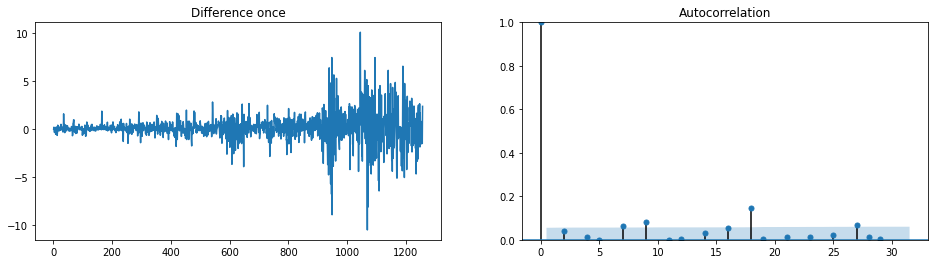

In [ ]:
diff = y.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

Commenter le choix des parametres.... 

## Etape 4: Construire le mod√®le pr√©dictif ARIMA

* **ARIMA(1,1,1)**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1. initialize the model
arima = ARIMA(y, order=(1, 1, 1))

# 2. fit the models
arima = arima.fit()

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1257
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2253.755
Method:                       css-mle   S.D. of innovations              1.454
Date:                Wed, 09 Jun 2021   AIC                           4515.509
Time:                        03:07:37   BIC                           4536.055
Sample:                             1   HQIC                          4523.231
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0803      0.037      2.143      0.032       0.007       0.154
ar.L1.D.Close    -0.3683      0.203     -1.812      0.070      -0.767       0.030
ma.L1.D.Close     0.2501      0.212      1.181      0.238      -0.165       0.665
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7155           +0.0000j            2.7155            0.5000
MA.1           -3.9992           +0.0000j            3.9992            0.5000
-----------------------------------------------------------------------------
"""

**REMARQUE(√† Am√©liorer):**
Il semble que les mod√®les ARIMA (1,1,1) ont moins de chance d'√™tre surajust√©s (les valeurs p restent faibles) et maintiennent un score AIC quasi similaire √† celui des autres mod√®les.

* **√âvaluer les performances du mod√®le**

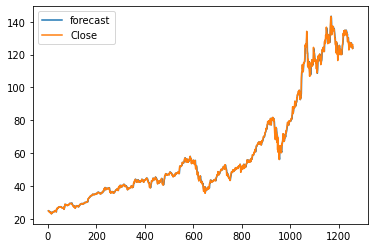

In [ ]:
 # Actual vs Fitted
arima.plot_predict(dynamic=False);

**REMARQUE:**

* **dynamic=False :** Il utilise en fait toutes les valeurs y disponibles afin de pr√©dire y_pred, ce qui fait que notre pr√©diction ARIMA utilise jusqu'√† ùë¶ùë°-1 pour pr√©dire ùë¶ùë° . 

* En r√©alit√©, nous n'avons pas acc√®s √† tous les y, surtout si nous voulons pr√©dire plusieurs intervalles dans le futur.


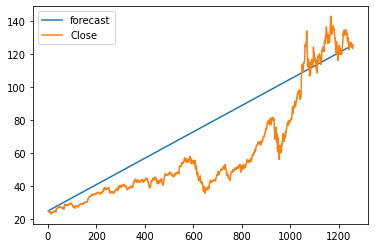

In [ ]:
arima.plot_predict(dynamic= True);

**REMARQUE:**

* **dynamic= True :** Si dynamic est True, les pr√©visions dans l'√©chantillon sont utilis√©es √† la place des variables d√©pendantes d√©cal√©es. La premi√®re valeur de pr√©vision est start.



## Etape 5: Pr√©diction r√©elle

Jusqu'√† pr√©sent notre mod√®le a vu **toute la s√©rie y** pendant la phase d'ajustement ! Pour cette raison, nous allons spliter nos donn√©es.

* **TRAIN-TEST-SPLIT :**
Nous divisons les donn√©es en un ensemble d'apprentissage (70 %) et un ensemble de test (30 %). 

In [ ]:
y_train = y[0:int(len(df)*0.7)]
y_test = y[int(len(df)*0.7):]
arima = ARIMA(y_train, order=(1, 2, 1)).fit() 

y_train.shape[0], y_test.shape[0]

(880, 378)

* Nous allons utiliser **la m√©thode .forecast()** sur notre ARIMA.fit() pour "pr√©voir" les 30% de points de donn√©es restant.

In [ ]:
(forecast, stderr, conf_int) = arima.forecast(378, alpha=0.05)

In [ ]:
forecast = pd.Series(forecast, name='forecast')
stderr = pd.Series(stderr)
conf_int = pd.DataFrame(conf_int, columns=['low', 'high'])

* Nous allons representer graphiquement les valeurs pr√©vues ainsi que la fourchette sup√©rieure et inf√©rieure de l'intervalle d'incertitude de 95%.

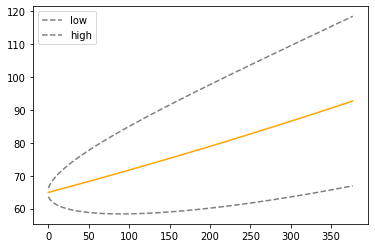

In [ ]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='grey', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend()

Tra√ßons nos points de donn√©es r√©els des 70% de points de donn√©es pr√©c√©dents pour mieux saisir les performances du mod√®le par rapport au pass√©.

In [ ]:
forecast.index = y_test.index
conf_int.index = y_test.index

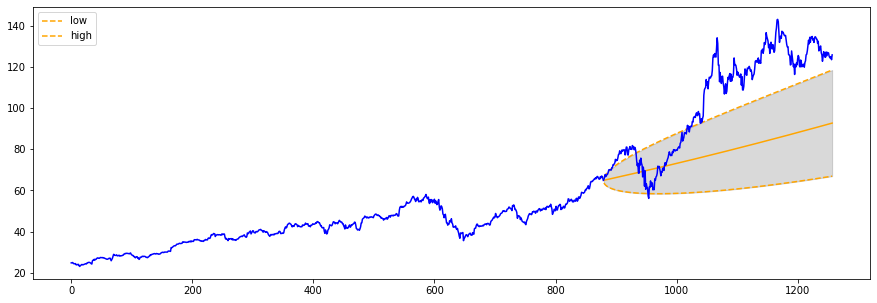

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='orange', ls='--')
plt.plot(conf_int['high'], label='high', c='orange', ls='--')
plt.plot(y_train, c='blue')
plt.plot(y_test, c='blue')
plt.legend()
plt.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15)

* **Verification des certaines hypoht√®ses portant sur les r√©sidus:** 
1. Distribution normale 
2. Moyenne constante 
3. Variance constante
4. Covariance constance 



(<matplotlib.axes._subplots.AxesSubplot at 0x7f027fd0ec10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f027fe90810>)

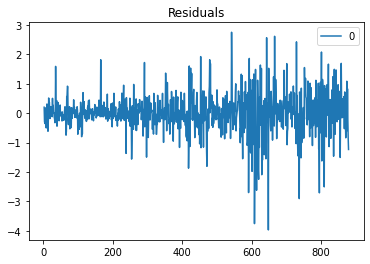

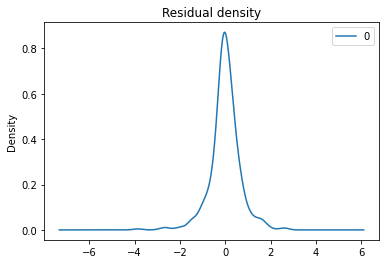

In [ ]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(title="Residuals"), residuals.plot(kind='kde', title='Residual density')

* **Metrics de performances :**

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [ ]:
forecast_accuracy(forecast, y_test)

{'acf1': 0.9873646459638652,
 'corr': 0.9066575466808161,
 'mae': 26.01081662206038,
 'mape': 0.2265469698333943,
 'me': -25.060866163723727,
 'minmax': 0.22566049672021515,
 'mpe': -0.21123754147610216,
 'rmse': 30.647919963628905}

## Etape 6: Grid Search

* **Executons notre propre gridsearch pour trouver nos meilleurs param√®tres(p,d,q)**

In [ ]:
import pmdarima as pm

model = pm.auto_arima(y_train, 
                      start_p=0, max_p=3,
                      start_q=0, max_q=3, 
                      d=None,           # let model determine 'd'
                      test='adf',       # using adftest to find optimal 'd'
                      trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

ModuleNotFoundError: ignored

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools

range_p = [0,1,2]
range_d = [1,2]
range_q = [0,1,2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]
        model = ARIMA(y_train, order=order).fit()
        # y_pred = model.forecast(len(y_test))[0] for unknown reason this crash
        # r2s.append(r2_score(y_pred, y_true))
        orders.append(order)
        aics.append(model.aic)
        
        
df = pd.DataFrame(list(zip(fold_idxs, orders, aics)),#, r2s)), 
                   columns =['Fold', '(p,d,q)', 'AIC'])#, 'R2'])

ValueError: ignored